<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/importing_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to import labels to a Kili project

In this tutorial, you will learn how to import labels to your project.

Here are the steps that we will follow:

1. Setting up a simple Kili project to work with
2. Importing some assets to the project
3. Importing model-based pre-annotations
4. Importing pre-existing labels

## Setting up a simple Kili project to work with

### Installing and instantiating Kili

First, let's install and import the required modules.

In [ ]:
%pip install  kili

In [ ]:
import os

from kili.client import Kili

Now, let's set up variables needed to create an instance of the Kili object.

We will need your API key and Kili's API endpoint.

If you are unsure how to look up your API key, refer to [https://docs.kili-technology.com/docs/creating-an-api-key](https://docs.kili-technology.com/docs/creating-an-api-key).

In [ ]:
kili = Kili(
    # api_endpoint="https://cloud.kili-technology.com/api/label/v2/graphql",
    # the line above can be uncommented and changed if you are working with an on-premise version of Kili
)

### Creating a basic Kili project

To create a Kili project, you must first set up its interface.

We will create a simple image project with just one simple classification job and two categories: `OBJECT_A` and `OBJECT_B`.

To learn more about Kili project interfaces, refer to [https://docs.kili-technology.com/docs/customizing-project-interface](https://docs.kili-technology.com/docs/customizing-project-interface).

In [ ]:
interface = {
    "jobs": {
        "JOB_0": {
            "mlTask": "CLASSIFICATION",
            "required": 1,
            "content": {
                "categories": {"OBJECT_A": {"name": "Object A"}, "OBJECT_B": {"name": "Object B"}},
                "input": "radio",
            },
        }
    }
}

result = kili.create_project(
    title="[Kili SDK Notebook]: Importing labels",
    description="Project Description",
    input_type="IMAGE",
    json_interface=interface,
)

For further processing, we will need to find out what our project ID is.

We can easily retrieve it from the project creation response message:

In [ ]:
project_id = result["id"]
print("Project ID: ", project_id)

Project ID:  clfwbvgpm00330jrne4n40m70


## Importing assets to Kili

Now, let's add some assets to be labeled.

We will use some free off-the-shelf examples from the Internet.

In [ ]:
url1 = "https://storage.googleapis.com/label-public-staging/car/car_2.jpg"
url2 = "https://storage.googleapis.com/label-public-staging/car/car_1.jpg"
url3 = "https://storage.googleapis.com/label-public-staging/recipes/inference/black_car.jpg"

asset_external_id_array = ["image_1", "image_2", "image_3"]

assets = kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[url1, url2, url3],
    external_id_array=asset_external_id_array,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


## Importing model-based pre-annotations into your project

When you import pre-annotations, you can use two types of labels: `PREDICTION` and `INFERENCE`.

`PREDICTION`-type annotations will be displayed on the asset during the labeling process. Labelers will be able to confirm what model produced, edit, and/or add new annotations.

Unlike `PREDICTION`-type labels, `INFERENCE`-type annotations are not displayed on the asset during the labeling process.
`INFERENCE`-type labels are used for IoU (intersection over union) calculation if you want to benchmark your model predictions, or labelers' work quality against ground truth.

For more information on Kili label types, refer to [our documentation](https://docs.kili-technology.com/reference/label-types).

First, let's prepare some fake predictions:

In [ ]:
json_response_array = [
    {"JOB_0": {"categories": [{"confidence": 95, "name": "OBJECT_B"}]}},
    {"JOB_0": {"categories": [{"confidence": 79, "name": "OBJECT_A"}]}},
    {"JOB_0": {"categories": [{"confidence": 83, "name": "OBJECT_B"}]}},
]

And let's upload them as `PREDICTION` labels:

In [ ]:
kili.append_labels(
    json_response_array=json_response_array,
    model_name="MyModel",
    label_type="PREDICTION",
    project_id=project_id,
    asset_external_id_array=asset_external_id_array,
)

In the project interface, you should now see your assets annotated by your model `MyModel`:

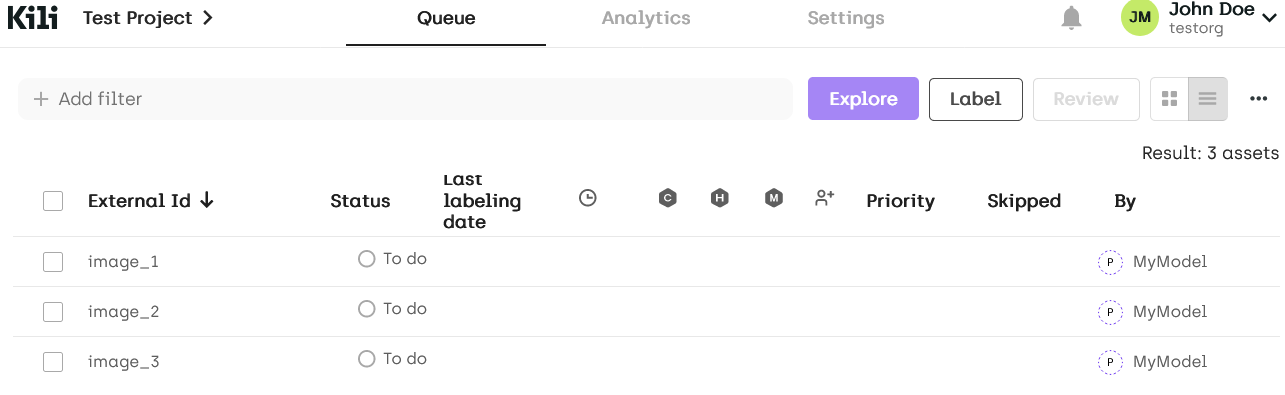

As well as the classes predicted by the model (class `OBJECT_B` for asset `image_1`):

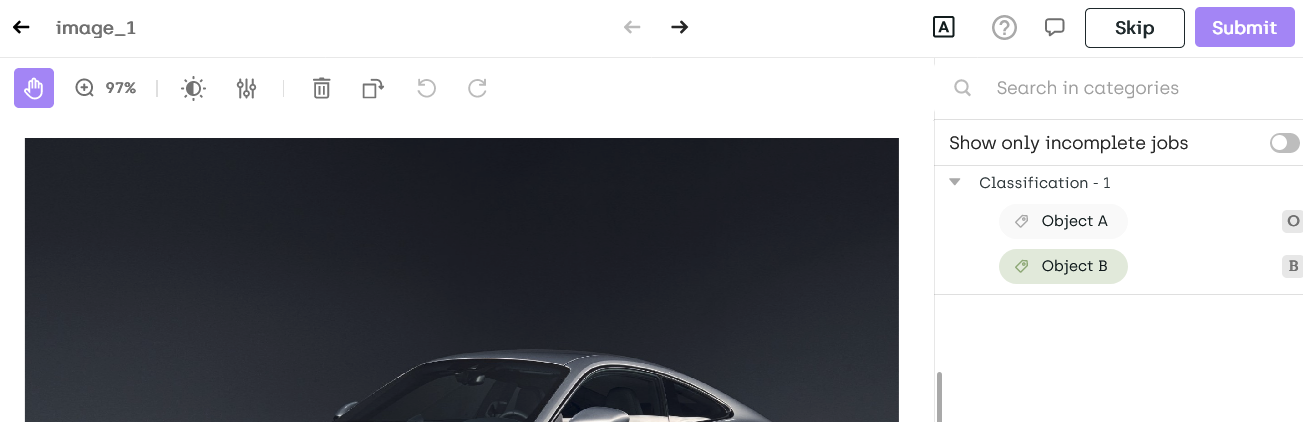

You can also add `PREDICTION`-type labels directly, using the `create_predictions` method. The `label_type` will be assigned automatically as `PREDICTION`:

In [ ]:
kili.create_predictions(
    project_id=project_id,
    external_id_array=asset_external_id_array,
    json_response_array=json_response_array,
    model_name="MyModel",
)

To import `INFERENCE`-type labels, just change the `label_type` argument of the `append_labels` method:

In [ ]:
kili.append_labels(
    json_response_array=json_response_array,
    model_name="MyModel",
    label_type="INFERENCE",
    project_id=project_id,
    asset_external_id_array=asset_external_id_array,
)

This time, the labels are not shown in the labeling interface anymore, since those labels are used as ground truth to compute some metrics later on:

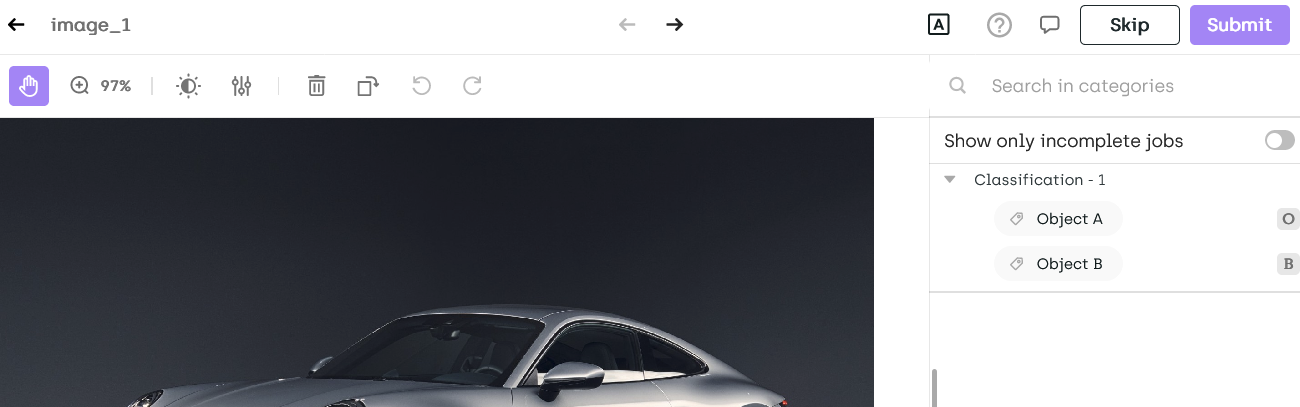

## Importing pre-existing labels into your project

If you want to copy and paste labels from other projects or other assets, add them with the `DEFAULT` label type. `DEFAULT` indicates that the label was generated by a human. 

In the example below, we take an existing annotation from asset `image_1`, and apply it to asset `image_2`:

In [ ]:
asset_image_1 = kili.assets(project_id=project_id, external_id_strictly_in=["image_1"])[0]

json_response = asset_image_1["labels"][-1]["jsonResponse"]

kili.append_labels(
    json_response_array=[json_response],
    label_type="DEFAULT",
    project_id=project_id,
    asset_external_id_array=["image_2"],
)

## Cleanup

We can remove the project that we created:

In [ ]:
kili.delete_project(project_id)

## Summary

Done. We've successfully set up a Kili project, imported assets to it, and then imported various types of labels to our project. Well done!